In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm


## train

In [2]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Create dataset and dataloaders
image_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/train/imgs', transform=transform)

# Calculate lengths for the splits
train_size = int(0.95 * len(image_dataset))
val_size = len(image_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [3]:
# Define Dice Loss
def dice_loss(inputs, targets, smooth=1):
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

In [4]:
# Define U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv_last(dec1))

In [5]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} ------> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
# Initialize model, optimizer, and loss function
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
loss_fn = dice_loss
num_epochs = 100

early_stopping = EarlyStopping(patience=5, verbose=True, path='/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/unet_best_model1.pth')

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, masks in train_loader_tqdm:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_loader_tqdm.set_postfix({"Train Loss": running_train_loss / (train_loader_tqdm.n + 1)})

    avg_train_loss = running_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    model.eval()
    running_val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", unit="batch")

    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            val_loss = loss_fn(outputs, masks)

            running_val_loss += val_loss.item()
            val_loader_tqdm.set_postfix({"Val Loss": running_val_loss / (val_loader_tqdm.n + 1)})

    avg_val_loss = running_val_loss / len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')

    torch.save(model.state_dict(),'/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/unet_latest_model.pth')

    scheduler.step(avg_val_loss)

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/100: 100%|██████████| 567/567 [01:14<00:00,  7.61batch/s, Train Loss=0.771]


Epoch 1, Training Loss: 0.7710


Validation 1/100: 100%|██████████| 30/30 [00:02<00:00, 14.33batch/s, Val Loss=0.782]


Epoch 1, Validation Loss: 0.7561
Validation loss decreased (inf ------> 0.756102).  Saving model ...


Epoch 2/100: 100%|██████████| 567/567 [01:16<00:00,  7.43batch/s, Train Loss=0.681]


Epoch 2, Training Loss: 0.6805


Validation 2/100: 100%|██████████| 30/30 [00:03<00:00,  9.86batch/s, Val Loss=0.628]


Epoch 2, Validation Loss: 0.6072
Validation loss decreased (0.756102 ------> 0.607203).  Saving model ...


Epoch 3/100: 100%|██████████| 567/567 [01:01<00:00,  9.21batch/s, Train Loss=0.608]


Epoch 3, Training Loss: 0.6078


Validation 3/100: 100%|██████████| 30/30 [00:01<00:00, 24.80batch/s, Val Loss=0.7]  


Epoch 3, Validation Loss: 0.6538
EarlyStopping counter: 1 out of 5


Epoch 4/100: 100%|██████████| 567/567 [00:56<00:00, 10.07batch/s, Train Loss=0.541]


Epoch 4, Training Loss: 0.5414


Validation 4/100: 100%|██████████| 30/30 [00:01<00:00, 24.95batch/s, Val Loss=0.755]


Epoch 4, Validation Loss: 0.7046
EarlyStopping counter: 2 out of 5


Epoch 5/100: 100%|██████████| 567/567 [00:58<00:00,  9.74batch/s, Train Loss=0.514]


Epoch 5, Training Loss: 0.5138


Validation 5/100: 100%|██████████| 30/30 [00:01<00:00, 24.82batch/s, Val Loss=0.782]


Epoch 5, Validation Loss: 0.7303
EarlyStopping counter: 3 out of 5


Epoch 6/100: 100%|██████████| 567/567 [00:58<00:00,  9.73batch/s, Train Loss=0.483]


Epoch 6, Training Loss: 0.4826


Validation 6/100: 100%|██████████| 30/30 [00:01<00:00, 21.30batch/s, Val Loss=0.724]


Epoch 6, Validation Loss: 0.6758
EarlyStopping counter: 4 out of 5


Epoch 7/100: 100%|██████████| 567/567 [00:58<00:00,  9.69batch/s, Train Loss=0.465]


Epoch 7, Training Loss: 0.4646


Validation 7/100: 100%|██████████| 30/30 [00:01<00:00, 24.16batch/s, Val Loss=0.633]


Epoch 7, Validation Loss: 0.5912
Validation loss decreased (0.607203 ------> 0.591206).  Saving model ...


Epoch 8/100: 100%|██████████| 567/567 [00:57<00:00,  9.90batch/s, Train Loss=0.464]


Epoch 8, Training Loss: 0.4642


Validation 8/100: 100%|██████████| 30/30 [00:01<00:00, 23.71batch/s, Val Loss=0.672]


Epoch 8, Validation Loss: 0.6269
EarlyStopping counter: 1 out of 5


Epoch 9/100: 100%|██████████| 567/567 [00:54<00:00, 10.39batch/s, Train Loss=0.453]


Epoch 9, Training Loss: 0.4526


Validation 9/100: 100%|██████████| 30/30 [00:01<00:00, 26.46batch/s, Val Loss=0.717]


Epoch 9, Validation Loss: 0.6688
EarlyStopping counter: 2 out of 5


Epoch 10/100: 100%|██████████| 567/567 [00:54<00:00, 10.36batch/s, Train Loss=0.43] 


Epoch 10, Training Loss: 0.4296


Validation 10/100: 100%|██████████| 30/30 [00:01<00:00, 21.97batch/s, Val Loss=0.712]


Epoch 10, Validation Loss: 0.6650
EarlyStopping counter: 3 out of 5


Epoch 11/100: 100%|██████████| 567/567 [00:54<00:00, 10.37batch/s, Train Loss=0.414]


Epoch 11, Training Loss: 0.4136


Validation 11/100: 100%|██████████| 30/30 [00:01<00:00, 25.91batch/s, Val Loss=0.678]


Epoch 11, Validation Loss: 0.6326
EarlyStopping counter: 4 out of 5


Epoch 12/100: 100%|██████████| 567/567 [00:54<00:00, 10.33batch/s, Train Loss=0.41] 


Epoch 12, Training Loss: 0.4094


Validation 12/100: 100%|██████████| 30/30 [00:01<00:00, 23.12batch/s, Val Loss=0.733]


Epoch 12, Validation Loss: 0.6842
EarlyStopping counter: 5 out of 5
Early stopping


## Test

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Define Dice Loss
def dice_loss(inputs, targets, smooth=1):
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

In [3]:
# Define U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv_last(dec1))

In [4]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/imgs', transform=transform)

In [5]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_loader)

50

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=1).to(device)

In [7]:
modelPath = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/unet_best_model.pth'
state_dict = torch.load(modelPath)
if "model_weight" in state_dict:
    model.load_state_dict(state_dict["model_weight"], strict=False)
else:
    model.load_state_dict(state_dict, strict=False)

model.to(device)

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

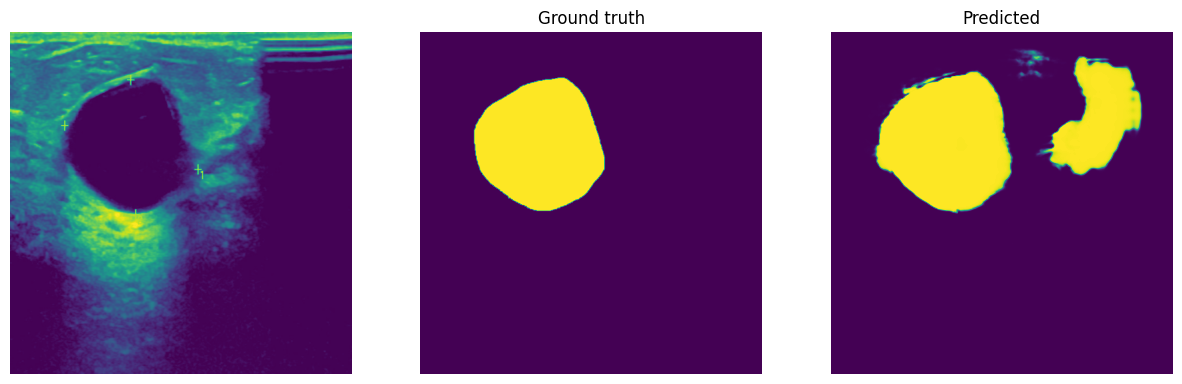

In [8]:
model.eval()
loss_fn = dice_loss
test_loss=[]
dsc_scores = []

for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)

    outputs = model(images)
    val_loss = loss_fn(outputs, masks)

    dsc = 1 - val_loss
    dsc_scores.append(dsc.item())


    test_loss.append(val_loss.item())

fig,axs=plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(images[0][0].cpu().detach().numpy())
#axs[0].set_title(str(num))
axs[0].axis('off')

axs[1].imshow(masks[0][0].cpu().detach().numpy())
axs[1].set_title("Ground truth")
axs[1].axis('off')

axs[2].imshow(outputs[0][0].cpu().detach().numpy())
axs[2].set_title("Predicted")
axs[2].axis('off')

plt.show()

In [9]:
from statistics import mean

mean(test_loss)

0.3716912913322449

In [10]:
from statistics import mean

mean(dsc_scores)

0.6283087086677551

In [11]:
import pandas as pd

df_dsc = pd.DataFrame(dsc_scores, columns=['DSC'])
df_dsc['Model'] = 'UNet'  # Replace with actual model name
df_dsc['Dataset'] = 'Breast Ultrasound'  # Replace with actual dataset name

# Save DataFrame to CSV
df_dsc.to_csv('dsc_scores_UNet_Breast Ultrasound.csv', index=False)

: 

## compare

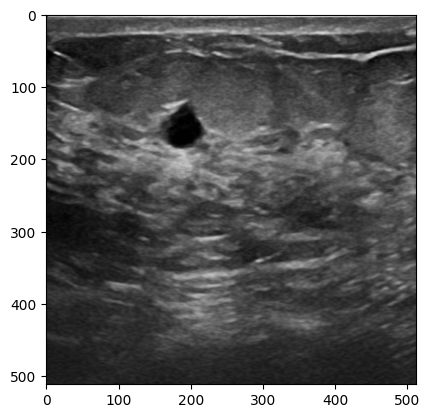

In [10]:
i=0
for img,mask in test_loader:
    i+=1
    if i==8:
        break


images=img[0]
images=images.permute(1,2,0)
plt.imshow(images)

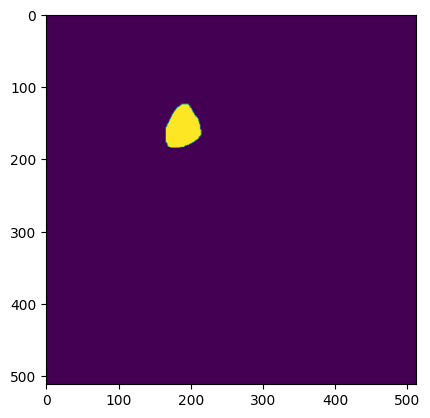

In [11]:
gt=mask[0]
gt=gt.permute(1,2,0)
plt.imshow(gt)

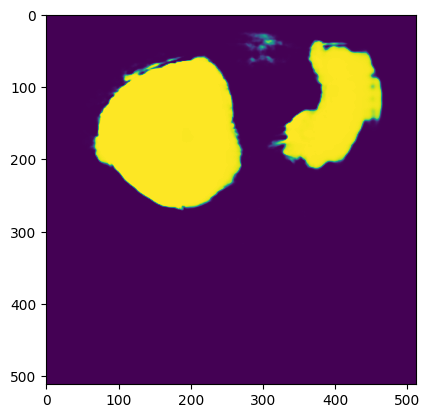

In [12]:
pred=outputs[0][0].cpu().detach().numpy()
plt.imshow(pred)

0.4880805015563965


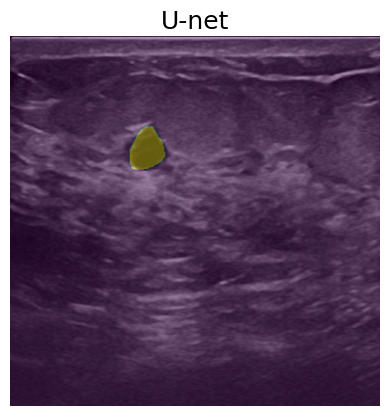

: 

In [13]:
i=0
for images, masks in test_loader:
    i+=1
    if i==8:
        break
    else:
        continue

images, masks = images.to(device), masks.to(device)

outputs = model(images)
val_loss = loss_fn(outputs, masks)

print(val_loss.item())

img=images[0][0].cpu().detach().numpy()
gt=masks[0][0].cpu().detach().numpy()
#pred=outputs[0][0].cpu().detach().numpy()


plt.imshow(img,cmap='gray')
plt.imshow(gt,alpha=0.4)

plt.title('U-net', fontsize=18)
plt.axis('off')

plt.show()